# Evaluate models

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import scipy.stats
from sklearn.metrics import mean_squared_error

from matplotlib.transforms import Affine2D

import matplotlib

# plt.style.use('dark_background')
plt.style.use('default')

### Task definition
Specify which task to evaluate: feature selection has been done for `detection_per_mol` and `regression_on_detected` only.

In [289]:
TASK_NAME = "detection_per_mol_sum"
# TASK_NAME = "regression_on_detected_per_mol_sum"

# TASK_NAME = "detection_per_ion"
# TASK_NAME = "regression_on_detected"
# TASK_NAME = "rank_matrices"
# TASK_NAME = "pytorch_nn_detection"
# TASK_NAME = "regression_on_detected_per_mol_max"
# TASK_NAME = "regression_on_detected_per_mol_sum"


EVAL_FEAT_SEL = False

### Define input files and score functions

In [290]:
# assert TASK_NAME in ["detection_per_mol",
#                      "detection_per_ion",
#                      "regression_on_detected",
#                      "rank_matrices",
#                      "pytorch_nn_detection"]

# if EVAL_FEAT_SEL:
#     assert TASK_NAME in ["detection_per_mol",
#                      "regression_on_detected"]

plots_dir = Path.cwd() / "../plots" / TASK_NAME
plots_dir.mkdir(exist_ok=True, parents=True)
results_dir = Path.cwd() / "../results" / TASK_NAME
raw_intensities_csv = Path.cwd() / "../input_data/intensity_data_raw.csv"


In [291]:
plots_dir = plots_dir / "paper_plots"



In [292]:
def get_scores(data, task_type="classification"):
    """
    FIXME: generalize for multiple classes
    :param data:
    :param task_type:
    :return:
    """
    if task_type == "classification":
        clf_report = classification_report(data.observed_value, data.prediction, output_dict=True, zero_division=0)
        scores = [clf_report['0']['precision'], clf_report['0']['recall'],
                  clf_report['0']['f1-score'], clf_report['0']['support'],
                  clf_report['1']['precision'], clf_report['1']['recall'],
                  clf_report['1']['f1-score'], clf_report['1']['support'],
                  clf_report['macro avg']['f1-score']]
        if data.observed_value.max() == 0:
            print("no detection!")
    elif task_type == "regression":
        spearman = scipy.stats.spearmanr(data.observed_value, data.prediction)
        pearson = scipy.stats.pearsonr(data.observed_value, data.prediction)
        mse = mean_squared_error(data.observed_value, data.prediction, squared=False)
        mse_std = mse / data['observed_value'].std()
        scores = [spearman[0], spearman[1],
                  pearson[0], pearson[1], mse, mse_std,
                  data[data['observed_value'] != 0].shape[0]]
    else:
        raise ValueError(task_type)
    return scores


Functions to compute scores:

In [293]:
def get_molecules_with_zero_formal_charge():
    raw_intensities_df = pd.read_csv(raw_intensities_csv, index_col=0)
    return raw_intensities_df[raw_intensities_df.formal_charge == 0.0]["name_short"].drop_duplicates().to_list()

molecules_with_zero_charge = get_molecules_with_zero_formal_charge()

In [294]:
def compute_scores(filenames, task_name, task_type,
                   eval_feat_selection=False,
                   test_all_adduct_setups=False,
                   load_multiple_thresholds=False,
                   thresh_column_name=None,
                   has_multiple_iterations=False,
                   name_global_column="global"):
    assert not (eval_feat_selection and load_multiple_thresholds)
    assert not (eval_feat_selection and has_multiple_iterations)
    assert not (load_multiple_thresholds and has_multiple_iterations)
    if load_multiple_thresholds:
        assert thresh_column_name is not None
    main_col_names = ['train_setup', 'model_type', 'adduct_setup']
    if eval_feat_selection: main_col_names += ['feat_sel_method', 'quantile', 'nb_features']
    if load_multiple_thresholds: main_col_names += [thresh_column_name]
    if has_multiple_iterations: main_col_names += ['iter_index']


    adduct_setups_settings = {
        "All adducts": {
            "adducts": ['-H', '+Cl', '[M]-', '+H', '[M]+', '+K', '+Na'],
            "only_zero_formal_charge": False
        }}
    if test_all_adduct_setups:
        extra_setups = {
            "Only '-H'/'+H' adducts and metabolites with zero formal charge": {
                "adducts": ['-H', '+H'],
                "only_zero_formal_charge": True
            },
            "No radicals adducts '[M]+'/'[M]-' and only metabolites with zero formal charge": {
                "adducts": ['-H', '+Cl', '+H', '+K', '+Na'],
                "only_zero_formal_charge": True
            }
        }
        adduct_setups_settings.update(extra_setups)

    all_model_typenames = np.array([
        "classifier",
        "regressor",
        "model_type"
    ])

    if "detection" in task_name:
        score_cols = ['not_det_precision', 'not_det_recall', 'not_det_f1', 'not_detected',
                      'det_precision', 'det_recall', 'det_f1', 'detected', 'macro_avg_f1_score']
    elif "regression" in task_name or "rank" in task_name:
        score_cols = ["Spearman's R", 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs']
    else:
        raise ValueError(task_name)

    # Define result dataframes:
    model_metrics = pd.DataFrame(columns=['matrix', 'polarity'] + main_col_names + score_cols)
    models_predictions = pd.DataFrame()
    counter = 0
    counter_global = 0

    # Loop over training configs:
    model_typename = None
    for train_setup in filenames:
        result_filename = filenames[train_setup]
        loc_models_results = pd.read_csv(results_dir / result_filename, index_col=0)
        loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                                'Polarity': 'polarity'})

        # Deduce model_typename:
        model_typename = all_model_typenames[np.isin(all_model_typenames, loc_models_results.columns.to_numpy())].item()

        if loc_models_results.prediction.isna().sum() != 0:
            print("NAN VALUES!! {}/{} for {}".format(loc_models_results.prediction.isna().sum(),
                                              loc_models_results.prediction.shape[0], train_setup),
                  )
            loc_models_results.loc[loc_models_results.prediction.isna(), "prediction"] = 0

        if loc_models_results.observed_value.dtype == "bool":
            loc_models_results.observed_value = np.where(loc_models_results.observed_value, 1, 0)
        if loc_models_results.prediction.dtype == "bool":
            loc_models_results.prediction = np.where(loc_models_results.prediction, 1, 0)
        if task_name == "pytorch_nn_detection" or ("detection" in task_name):
            # Binarize predictions:
            loc_models_results.prediction = np.where(loc_models_results.prediction > 0.5, 1, 0)

        if "regression" in task_name:
            # Remove undetected from regression score:
            loc_models_results = loc_models_results[loc_models_results['observed_value'] != 0]
        elif "rank" in task_name:
            # Remove nan and not-detected from score computation:
            loc_models_results = loc_models_results[loc_models_results['observed_value'] > 0]

        loc_models_results["train_setup"] = train_setup
        models_predictions = pd.concat([models_predictions, loc_models_results])

        # Loop over adduct setups:
        for adduct_setup in adduct_setups_settings:
            # print(adduct_setup)
            # Filter results according to the adduct setup:
            used_adducts = adduct_setups_settings[adduct_setup]["adducts"]
            # print(f"Kept {np.isin(loc_models_results.adduct, used_adducts).sum()} rows out of {loc_models_results.shape}")

            if "adduct" in loc_models_results.columns.to_list():
                loc_models_results_adduct_setup = loc_models_results[np.isin(loc_models_results.adduct, used_adducts)]
            else:
                loc_models_results_adduct_setup = loc_models_results.copy()
            if adduct_setups_settings[adduct_setup]["only_zero_formal_charge"]:
                # print("Removing formal charge...")
                loc_models_results_adduct_setup = loc_models_results[np.isin(loc_models_results.name_short, molecules_with_zero_charge)]

            # Loop over matrices and model types:
            groupby_cols = ['matrix', 'polarity', model_typename]
            if eval_feat_selection: groupby_cols += ['feat_sel_method', 'feat_sel_quantile']
            if has_multiple_iterations: groupby_cols += ['iter_index']
            if load_multiple_thresholds: groupby_cols += [thresh_column_name]
            sum_shape = 0



            for groupby_items, rows in loc_models_results_adduct_setup.groupby(groupby_cols):
                # Compute scores:
                sum_shape += rows.shape[0]
                matrix, polarity, model_type = groupby_items[:3]
                # print(train_setup, groupby_items, rows.shape)
                scores = get_scores(rows, task_type=task_type)

                # Prepare new row of database with scores:
                new_result_row = [matrix, polarity, train_setup, model_type, adduct_setup]
                if eval_feat_selection:
                    feat_sel_met, quantile = groupby_items[3:]
                    new_result_row += [feat_sel_met, round(quantile * 6), rows["nb_features"].drop_duplicates()[0]]
                elif load_multiple_thresholds or has_multiple_iterations:
                    extra_item = groupby_items[3]
                    new_result_row += [extra_item]

                model_metrics.loc[counter] = new_result_row + scores
                counter += 1

            print(sum_shape)

            # Compute global scores:
            # Loop over model types:
            groupby_cols = [model_typename]
            if eval_feat_selection: groupby_cols += ['feat_sel_method', 'feat_sel_quantile']
            if load_multiple_thresholds: groupby_cols += [thresh_column_name]
            if has_multiple_iterations: groupby_cols += ['iter_index']
            print(loc_models_results_adduct_setup.shape)
            for groupby_items, rows in loc_models_results_adduct_setup.groupby(groupby_cols):
                # Compute global scores:
                # print(train_setup, groupby_items, rows.shape)
                model_type = groupby_items[0] if (eval_feat_selection or load_multiple_thresholds or has_multiple_iterations) else groupby_items
                scores = get_scores(rows, task_type=task_type)

                # Prepare new row of database with scores:
                new_result_row = [name_global_column, "", train_setup, model_type, adduct_setup]
                if eval_feat_selection:
                    feat_sel_met, quantile = groupby_items[1:]
                    new_result_row += [feat_sel_met,  round(quantile * 6), rows["nb_features"].drop_duplicates()[0]]
                elif load_multiple_thresholds or has_multiple_iterations:
                   extra_item = groupby_items[1]
                   new_result_row += [extra_item]

                # model_metrics_global.loc[counter_global] = new_result_row + scores
                model_metrics.loc[counter] = new_result_row + scores
                counter += 1

            # Compute global scores for positive and negative polarities separately:
            groupby_cols += ["polarity"]
            for groupby_items, rows in loc_models_results_adduct_setup.groupby(groupby_cols):
                # Compute global scores:
                model_type = groupby_items[0]
                polarity = groupby_items[-1]
                scores = get_scores(rows, task_type=task_type)

                # Prepare new row of database with scores:
                new_result_row = [name_global_column, polarity, train_setup, model_type, adduct_setup]
                if eval_feat_selection:
                    feat_sel_met, quantile = groupby_items[1:-1]
                    new_result_row += [feat_sel_met,  round(quantile * 6), rows["nb_features"].drop_duplicates()[0]]
                elif load_multiple_thresholds or has_multiple_iterations:
                   extra_item = groupby_items[1]
                   new_result_row += [extra_item]

                # model_metrics_global.loc[counter_global] = new_result_row + scores
                model_metrics.loc[counter] = new_result_row + scores
                counter += 1



    if not test_all_adduct_setups:
        # TODO: remove extra duplicates
        pass

    return model_metrics, models_predictions, model_typename



## Final paper plots over multiple iterations

In [295]:
OUR_MODEL_NAME = "NeuralNet"


selected_model = "MLP"
plots_dir.mkdir(exist_ok=True, parents=True)

# Final results sklearn_v1
filenames = {
    OUR_MODEL_NAME: "sklearn_v1/results_mol_feat.csv",
    "Baseline": "sklearn_v1/results_random_feat.csv",
}

formatted_metric_names = {
    "macro_avg_f1_score": "Macro-Avg-F1 Score",
    "Spearman's R": "Spearman's R"
}

# # Rename baseline in case we do not give adduct information:
# if "per_mol" in TASK_NAME:
#     filenames["Baseline (no input features)"] =  filenames.pop("Baseline (only adduct info)")


In [296]:
if "detection" in TASK_NAME:
    metric = "macro_avg_f1_score"
    count_key = 'detected'
    task_typename = "classification"
elif "regression" in TASK_NAME or "rank" in TASK_NAME:
    metric = "Spearman's R"
    count_key = 'non-zero obs'
    task_typename = "regression"
else:
    raise ValueError(TASK_NAME)



In [297]:
GLOBAL_STRING = r"\textbf{Global}"
# Compute the actual scores:
model_metrics, models_predictions, model_typename = \
    compute_scores(filenames, TASK_NAME, task_typename, eval_feat_selection=False, has_multiple_iterations=True,
                   name_global_column=GLOBAL_STRING)


35540
(35540, 9)
35540
(35540, 9)


In [298]:
# model_metrics[(model_metrics.matrix == GLOBAL_STRING) & (model_metrics.polarity == "positive")]

Reshape predictions for paper and Veronika:

In [299]:
# exported_predictions = models_predictions[models_predictions.train_setup == OUR_MODEL_NAME].drop(columns=[model_typename, "fold", "train_setup"])
# index_columns = ["matrix", "polarity", "name_short"]
#
# if task_typename == "regression":
#     mean_predictions = exported_predictions.groupby(index_columns, as_index=True).mean().drop(columns="iter_index")
# elif task_typename == "classification":
#     total_nb_iterations = exported_predictions.iter_index.max() + 1
#     mean_predictions = exported_predictions.groupby(index_columns, as_index=True).sum().drop(columns="iter_index")
#     mean_predictions /= float(total_nb_iterations)
#     mean_predictions = (mean_predictions > 0.5).astype("int")
# else:
#     raise ValueError(task_typename)
# mean_predictions.reset_index().to_c


In [300]:
index_columns = ["matrix", "polarity","train_setup","model_type","adduct_setup"]

# Take avg and std over multiple iterations:
std_metrics = model_metrics.groupby(index_columns, as_index=True).std().drop(columns="iter_index")
mean_metrics = model_metrics.groupby(index_columns, as_index=True).mean().drop(columns="iter_index")
mean_metrics = mean_metrics.join(std_metrics, lsuffix='_mean', rsuffix='_std').reset_index()
mean_metrics.head()

,matrix,polarity,train_setup,model_type,adduct_setup,not_det_precision_mean,not_det_recall_mean,not_det_f1_mean,not_detected_mean,det_precision_mean,...,macro_avg_f1_score_mean,not_det_precision_std,not_det_recall_std,not_det_f1_std,not_detected_std,det_precision_std,det_recall_std,det_f1_std,detected_std,macro_avg_f1_score_std
0,9AA,negative,Baseline,MLP,All adducts,0.292915,0.629268,0.399527,41.0,0.797327,...,0.502734,0.008642,0.035993,0.012456,0.0,0.010465,0.029185,0.022202,0.0,0.012293
1,9AA,negative,NeuralNet,MLP,All adducts,0.570760,0.629268,0.598415,41.0,0.871051,...,0.727065,0.021953,0.034108,0.025601,0.0,0.010768,0.009621,0.008270,0.0,0.016689
2,9AA,positive,Baseline,MLP,All adducts,0.551573,0.520000,0.535002,90.0,0.401919,...,0.475735,0.009192,0.033457,0.021636,0.0,0.008463,0.022249,0.010238,0.0,0.009613
3,9AA,positive,NeuralNet,MLP,All adducts,0.763208,0.754444,0.758668,90.0,0.675029,...,0.719244,0.013836,0.012228,0.007660,0.0,0.010175,0.025804,0.015047,0.0,0.010691
4,CHCA,negative,Baseline,MLP,All adducts,0.581079,0.596429,0.588368,84.0,0.514794,...,0.547286,0.013251,0.033414,0.021116,0.0,0.018091,0.024888,0.016480,0.0,0.015267


In [301]:
ecolors = [
    'lightgreen',
    'lightcoral',
    'lightblue'
]
dot_colors = [
    'black',
    'black',
    'black',
    # 'orange',
    # 'mediumpurple',
    # 'blue',
]

In [302]:
# import time
#
# # print(f"Plot results for task {TASK_NAME}:")
# # plt.rcParams.update({'font.size': 10})
# # fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
# # ax_list = axes.flat
# matplotlib.rc('text', usetex=True)
#
# # transformations = [
# #     Affine2D().translate(-0., 0.0) + ax.transData,
# #     Affine2D().translate(0., 0.0) + ax.transData
# # ]
#
#
#
# for polarity in ["positive", "negative"]:
#     filtered_metrics = mean_metrics[mean_metrics.polarity == polarity].sort_values(metric + '_mean', ascending=False)
#     # print(f"Plot results for task {TASK_NAME}:")
#
#
#     # ----------------------
#     # First, plot scores:
#     # ----------------------
#     plt.rcParams.update({'font.size': 15})
#     fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 8))
#     # Sort matrices according to score:
#     sorted_matrices = filtered_metrics[filtered_metrics.train_setup == OUR_MODEL_NAME].sort_values(
#         metric + '_mean', ascending=False).matrix.reset_index(drop=True)
#     # Move the global score at the end:
#     target_row = sorted_matrices[sorted_matrices == GLOBAL_STRING].index.item()
#     idx = [i for i in range(len(sorted_matrices)) if i != target_row] + [target_row]
#     sorted_matrices = sorted_matrices.iloc[idx]
#
#     filtered_metrics = filtered_metrics.sort_values('train_setup', ascending=False)
#     for i, (train_setup, rows) in enumerate(filtered_metrics.groupby("train_setup", sort=False)):
#         # print(train_setup)
#         p = ax.errorbar(sorted_matrices, metric + '_mean', linestyle="none", yerr=metric+'_std', data=rows.set_index("matrix", drop=True).loc[sorted_matrices],
#                     fmt = 'o',color = dot_colors[i], ecolor = ecolors[i], elinewidth = 5, capsize=10,
#                  label=train_setup)
#         # # Add a line separating the global results:
#         # ax.axvline(x=10.5)
#
#     # mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
#     ax.legend(loc="lower left")
#     ax.set_ylabel(formatted_metric_names[metric])
#     ax.set_xlabel("Matrix type")
#     # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
#     ylims = [0.3, 0.8]
#     ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.05, 0.05))
#     ax.grid(visible=True, alpha=0.3,
#             # axis='y'
#             )
#     ax.set_title(f"Polarity: {polarity}")
#     fig.tight_layout()
#     fig.savefig(plots_dir / f"{selected_model}_scores_{polarity}.pdf")
#
#     # ----------------------
#     # Then, plot differences:
#     # ----------------------
#
#     plt.rcParams.update({'font.size': 15})
#     fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 8))
#     # Compute differences:
#     filtered_metrics.loc[filtered_metrics.train_setup == "Baseline", metric + '_mean'] *= -1
#     difference_scores = filtered_metrics.groupby("matrix").apply(lambda grp: grp[[metric + '_mean', metric+'_std']].sum())
#
#     # Sort:
#     sorted_matrices = difference_scores.sort_values(metric + '_mean', ascending=False).index.to_list()
#     sorted_matrices.pop(sorted_matrices.index(GLOBAL_STRING))
#     sorted_matrices.append(GLOBAL_STRING)
#
#     ax.errorbar(sorted_matrices, metric + '_mean', linestyle="none", yerr=metric+'_std',
#                 data=difference_scores.loc[sorted_matrices],
#                     fmt = 'o',color = dot_colors[2], ecolor = ecolors[2], elinewidth = 5, capsize=10,
#                  )
#     # # Add a line separating the global results:
#     # ax.axvline(x=10.5)
#
#     # mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
#     ax.legend(loc="lower left")
#     ax.set_ylabel(f"Difference between model and baseline ({formatted_metric_names[metric]})")
#     ax.set_xlabel("Matrix type")
#     # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
#     # ylims = [0.3, 0.8]
#     # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.05, 0.05))
#     ax.grid(visible=True, alpha=0.3,
#             # axis='y'
#             )
#     ax.set_title(f"Polarity: {polarity}")
#     fig.tight_layout()
#     fig.savefig(plots_dir / f"{selected_model}_difference_scores_{polarity}.pdf")
#     plt.close()
#     # fig.close()
#     # break



Global scores plot:

In [303]:
# filtered_metrics = mean_metrics[mean_metrics.matrix == GLOBAL_STRING].sort_values(metric + '_mean', ascending=False)
# filtered_metrics["Matrix and polarity"] = "Global (" + filtered_metrics["polarity"] + ")"
# filtered_metrics.loc[filtered_metrics.polarity == "", "Matrix and polarity"] = "Global"
# # print(f"Plot results for task {TASK_NAME}:")
#
# filtered_metrics = filtered_metrics.sort_values("Matrix and polarity", ascending=False)
# filtered_metrics

In [304]:
# # ----------------------
# # First, plot scores:
# # ----------------------
# plt.rcParams.update({'font.size': 15})
# fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 8))
#
# for i, (train_setup, rows) in enumerate(filtered_metrics.groupby("train_setup", sort=False)):
#     # print(train_setup)
#     p = ax.errorbar("Matrix and polarity", metric + '_mean', linestyle="none", yerr=metric+'_std', data=rows,
#                 fmt = 'o',color = dot_colors[i], ecolor = ecolors[i], elinewidth = 5, capsize=10,
#              label=train_setup)
#     # # Add a line separating the global results:
#     # ax.axvline(x=10.5)
#
# # mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
# ax.legend(loc="lower left")
# ax.set_ylabel(formatted_metric_names[metric])
# # ax.set_xlabel("Matrix type")
# # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
# # ylims = [0.3, 0.8]
# # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.05, 0.05))
# ax.grid(visible=True, alpha=0.3,
#         # axis='y'
#         )
# ax.set_xlim(-1,3)
# # ax.set_title(f"Polarity: {polarity}")
# # fig.tight_layout()
# fig.savefig(plots_dir / f"{selected_model}_global_scores.pdf")

Put all plots together:

In [305]:
dot_colors = [
    'black',
    'black',
    'black',
    # 'orange',
    # 'mediumpurple',
    # 'blue',
]


global_labels = {
    "": "All",
    "positive": "Positive",
    "negative": "Negative"
}

polarity_labels = {
    "positive": "Positive",
    "negative": "Negative"
}


In [306]:
mean_metrics

,matrix,polarity,train_setup,model_type,adduct_setup,not_det_precision_mean,not_det_recall_mean,not_det_f1_mean,not_detected_mean,det_precision_mean,...,macro_avg_f1_score_mean,not_det_precision_std,not_det_recall_std,not_det_f1_std,not_detected_std,det_precision_std,det_recall_std,det_f1_std,detected_std,macro_avg_f1_score_std
0,9AA,negative,Baseline,MLP,All adducts,0.292915,0.629268,0.399527,41.0,0.797327,...,0.502734,0.008642,0.035993,0.012456,0.0,0.010465,0.029185,0.022202,0.0,0.012293
1,9AA,negative,NeuralNet,MLP,All adducts,0.570760,0.629268,0.598415,41.0,0.871051,...,0.727065,0.021953,0.034108,0.025601,0.0,0.010768,0.009621,0.008270,0.0,0.016689
2,9AA,positive,Baseline,MLP,All adducts,0.551573,0.520000,0.535002,90.0,0.401919,...,0.475735,0.009192,0.033457,0.021636,0.0,0.008463,0.022249,0.010238,0.0,0.009613
3,9AA,positive,NeuralNet,MLP,All adducts,0.763208,0.754444,0.758668,90.0,0.675029,...,0.719244,0.013836,0.012228,0.007660,0.0,0.010175,0.025804,0.015047,0.0,0.010691
4,CHCA,negative,Baseline,MLP,All adducts,0.581079,0.596429,0.588368,84.0,0.514794,...,0.547286,0.013251,0.033414,0.021116,0.0,0.018091,0.024888,0.016480,0.0,0.015267
5,CHCA,negative,NeuralNet,MLP,All adducts,0.742344,0.802381,0.771126,84.0,0.745645,...,0.739784,0.011855,0.017923,0.012641,0.0,0.018879,0.017568,0.015159,0.0,0.013590
6,CHCA,positive,Baseline,MLP,All adducts,0.085488,0.284211,0.131316,19.0,0.864014,...,0.418859,0.012802,0.027179,0.017730,0.0,0.010118,0.035173,0.027782,0.0,0.021929
7,CHCA,positive,NeuralNet,MLP,All adducts,0.411242,0.489474,0.446271,19.0,0.931366,...,0.682779,0.027731,0.025423,0.019131,0.0,0.002974,0.010880,0.005489,0.0,0.011705
8,CMBT,negative,Baseline,MLP,All adducts,0.720864,0.542593,0.619057,108.0,0.329672,...,0.510803,0.010455,0.013940,0.010663,0.0,0.011013,0.024670,0.014782,0.0,0.010828
9,CMBT,negative,NeuralNet,MLP,All adducts,0.810893,0.805556,0.808191,108.0,0.559568,...,0.685948,0.012510,0.009760,0.010152,0.0,0.022842,0.031796,0.026531,0.0,0.018175


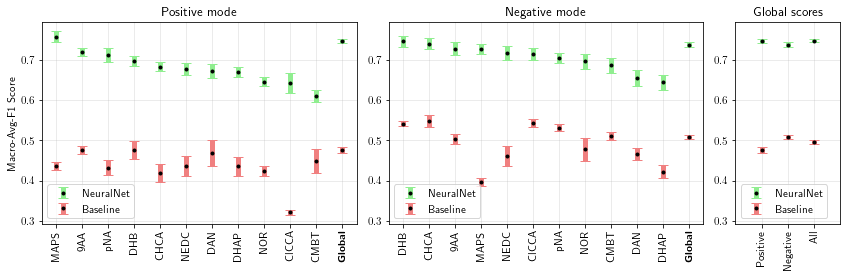

In [308]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(ncols=3,nrows=1, figsize= (12, 4), gridspec_kw={'width_ratios': [3, 3, 1]})
axes = np.array([axes])

error_bars_kwargs = { "linestyle" :"none",
                      "elinewidth": 5,
                      "capsize": 5,
                      "fmt": '.'
                      }

plt.xticks(rotation='vertical')
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=11)
    # ax.set_xticks(rotation='vertical')

for pol_idx, polarity in enumerate(["positive", "negative"]):
    ax = axes[0, pol_idx]
    filtered_metrics = mean_metrics[mean_metrics.polarity == polarity].sort_values(metric + '_mean', ascending=False)
    # print(f"Plot results for task {TASK_NAME}:")
    # plt.rcParams.update({'font.size': 16})
    # mean_metrics["Matrix (polarity)"] = mean_metrics["matrix"] + " (" + mean_metrics["polarity"] + ")"

# fig.tight_layout(h_pad=3, w_pad=2)
# fig.savefig(plots_dir / f"{task_typename}_global_plot.pdf")
#
    sorted_matrices = filtered_metrics[filtered_metrics.train_setup == OUR_MODEL_NAME].sort_values(
        metric + '_mean', ascending=False).matrix.reset_index(drop=True)
    # Move the global score at the end:
    target_row = sorted_matrices[sorted_matrices == GLOBAL_STRING].index.item()
    idx = [i for i in range(len(sorted_matrices)) if i != target_row] + [target_row]
    sorted_matrices = sorted_matrices.iloc[idx]
    # print(sorted_matrices)



    filtered_metrics = filtered_metrics.sort_values('train_setup', ascending=False)
    for i, (train_setup, rows) in enumerate(filtered_metrics.groupby("train_setup", sort=False)):
        # print(rows)
        df_to_plot = rows.set_index("matrix", drop=True).loc[sorted_matrices]
        if task_typename == "regression":
            x_labels =  pd.Series(sorted_matrices.astype("str").to_numpy() + " (" + df_to_plot["non-zero obs_mean"].astype("int").astype("str").to_numpy() + ")",
                                        index=sorted_matrices.index)
        else:
            x_labels = sorted_matrices

        ax.errorbar(x_labels.to_numpy(), df_to_plot[metric + '_mean'].to_numpy(), yerr=df_to_plot[metric+'_std'].to_numpy(),
                    color = dot_colors[i], ecolor = ecolors[i],
                  label=train_setup, **error_bars_kwargs)
        # # Add a line separating the global results:
        # ax.axvline(x=10.5)

    # mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
    ax.legend(loc="lower left")
    if pol_idx == 0:
        ax.set_ylabel(formatted_metric_names[metric])
    # ax.set_xlabel("Matrix type")
    # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3,
            # axis='y'
            )
    ax.set_title(f"{polarity_labels[polarity]} mode")
    plt.sca(ax)
    plt.xticks(rotation=90)

# ----------------------
# Global scores, plot scores:
# ----------------------
ax = axes[0,2]
filtered_metrics = mean_metrics[mean_metrics.matrix == GLOBAL_STRING].sort_values(metric + '_mean', ascending=False)
x_labels = pd.Series([global_labels[pol] for pol in filtered_metrics["polarity"]]).astype("str")
if task_typename == "regression":
    x_labels =  x_labels.to_numpy() + " (" + filtered_metrics["non-zero obs_mean"].astype("int").astype("str").to_numpy() + ")"
else:
    x_labels = x_labels.to_numpy()
filtered_metrics["Matrix and polarity"] = pd.Series(x_labels, index=filtered_metrics.index)
# filtered_metrics["Matrix and polarity"] = filtered_metrics["polarity"] + " polarity"
# filtered_metrics.loc[filtered_metrics.polarity == "", "Matrix and polarity"] = "All matrices"
# print(f"Plot results for task {TASK_NAME}:")

filtered_metrics = filtered_metrics.sort_values("Matrix and polarity", ascending=False)

for i, (train_setup, rows) in enumerate(filtered_metrics.groupby("train_setup", sort=False)):
    # print(train_setup)
    # df_to_plot = rows.set_index("matrix", drop=True).loc[sorted_matrices]
    # if task_typename == "regression":
    #     x_labels =  pd.Series(sorted_matrices.astype("str").to_numpy() + "(" + df_to_plot["non-zero obs_mean"].astype("int").astype("str").to_numpy() + ")",
    #                                 index=sorted_matrices.index)
    # else:
    #     x_labels = sorted_matrices

    # ax.errorbar(x_labels.to_numpy(), df_to_plot[metric + '_mean'].to_numpy(), yerr=df_to_plot[metric+'_std'].to_numpy(),
    #             color = dot_colors[i], ecolor = ecolors[i],
    #           label=train_setup, **error_bars_kwargs)

    p = ax.errorbar("Matrix and polarity", metric + '_mean', yerr=metric+'_std', data=rows,
                color = dot_colors[i], ecolor = ecolors[i],
             label=train_setup, **error_bars_kwargs)
    # # Add a line separating the global results:
    # ax.axvline(x=10.5)

# mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
ax.legend(loc="lower left")
# ax.set_ylabel(formatted_metric_names[metric])

# ax.set_xlabel("Matrix type")
# ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
# ylims = [0.3, 0.8]
# ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.05, 0.05))
ax.grid(visible=True, alpha=0.3,
        # axis='y'
        )
ax.set_xlim(-1,3)
ax.set_title("Global scores")
plt.sca(ax)
plt.xticks(rotation=90)




axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,1])
axes[0,0].get_shared_y_axes().join(axes[0,0], axes[0,2])

# axes[1,0].get_shared_y_axes().join(axes[1,0], axes[1,1])
# axes[1,0].get_shared_y_axes().join(axes[1,0], axes[1,2])


fig.tight_layout(h_pad=2, w_pad=1)
fig.savefig(plots_dir / f"{task_typename}_scores.pdf")

In [231]:
x_labels = pd.Series([global_labels[pol] for pol in filtered_metrics["polarity"]]).astype("str")
if task_typename == "regression":
    x_labels =  x_labels.to_numpy() + " (" + filtered_metrics["non-zero obs_mean"].astype("int").astype("str").to_numpy() + ")"
x_labels

array(['Positive (1167)', 'Positive (1167)', 'Negative (847)',
       'Negative (847)', 'All (2014)', 'All (2014)'], dtype=object)

In [171]:
    # # ----------------------
    # # Then, plot differences:
    # # ----------------------
    # ax = axes[1, pol_idx]
    # # Compute differences:
    # filtered_metrics.loc[filtered_metrics.train_setup == "Baseline", metric + '_mean'] *= -1
    # difference_scores = filtered_metrics.groupby("matrix").apply(lambda grp: grp[[metric + '_mean', metric+'_std']].sum())
    #
    # # Sort:
    # sorted_matrices = difference_scores.sort_values(metric + '_mean', ascending=False).index.to_list()
    # sorted_matrices.pop(sorted_matrices.index(GLOBAL_STRING))
    # sorted_matrices.append(GLOBAL_STRING)
    #
    # ax.errorbar(sorted_matrices, metric + '_mean', yerr=metric+'_std',
    #             data=difference_scores.loc[sorted_matrices],
    #                color = dot_colors[2], ecolor = ecolors[2],
    #              **error_bars_kwargs)
    # # # Add a line separating the global results:
    # # ax.axvline(x=10.5)
    #
    # # mean_metrics.set_index(["matrix", "train_setup"], drop=True)[metric].unstack("train_setup").plot.err(ax=ax)
    # # ax.legend(loc="lower left")
    # if pol_idx == 0:
    #     ax.set_ylabel(f"Difference model and baseline \n({formatted_metric_names[metric]})")
    # # ax.set_xlabel("Matrix type")
    # # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    # # ylims = [0.3, 0.8]
    # # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.05, 0.05))
    # ax.grid(visible=True, alpha=0.3,
    #         # axis='y'
    #         )
    # ax.set_title(f"{polarity_labels[polarity]} mode")
    # # ax.set_title(f"Matrices with {polarity} polarity")
    # plt.sca(ax)
    # plt.xticks(rotation=90)


# # -------------------
# # Now the difference:
# # -------------------
# ax = axes[1,2]
# filtered_metrics.loc[filtered_metrics.train_setup == "Baseline", metric + '_mean'] *= -1
# difference_scores = filtered_metrics.groupby("Matrix and polarity").apply(lambda grp: grp[[metric + '_mean', metric+'_std']].sum())
#
# difference_scores = difference_scores.sort_values("Matrix and polarity", ascending=False)
#
# ax.errorbar(difference_scores.index, metric + '_mean', yerr=metric+'_std',
#             data=difference_scores,
#                color = dot_colors[2], ecolor = ecolors[2],
#              **error_bars_kwargs)
#
# ax.grid(visible=True, alpha=0.3,
#         # axis='y'
#         )
# ax.set_xlim(-1,3)
# ax.set_title("Global scores")
# plt.sca(ax)
# plt.xticks(rotation=90)



,polarity,train_setup,model_type,adduct_setup,Spearman's R_mean,S pval_mean,Pearson's R_mean,P pval_mean,RMSE_mean,RMSE/std_mean,non-zero obs_mean,Spearman's R_std,S pval_std,Pearson's R_std,P pval_std,RMSE_std,RMSE/std_std,non-zero obs_std,Matrix and polarity
matrix,,,,,,,,,,,,,,,,,,,
\textbf{Global},positive,Baseline,MLP,All adducts,0.204851,2.381821e-12,0.217815,6.757174e-14,1.014592,0.988365,1167.0,0.004221,1.973662e-12,0.002576,5.572890e-14,0.001157,0.001127,0.0,Positive
\textbf{Global},negative,Baseline,MLP,All adducts,0.461676,7.932711e-46,0.475269,7.324234e-49,0.946302,0.882909,847.0,0.001513,6.470289e-46,0.001348,4.376093e-49,0.000911,0.000850,0.0,Negative
\textbf{Global},,Baseline,MLP,All adducts,0.349544,9.434871e-59,0.358966,3.415947e-62,0.986449,0.939752,2014.0,0.001461,8.462351e-59,0.000872,2.908985e-62,0.000532,0.000507,0.0,All


In [60]:
p.lines[-1].coord

# rows.set_index("matrix", drop=True).loc[sorted_matrices]
# sorted_matrices

AttributeError: 'tuple' object has no attribute 'coord'

### Load predictions and compute scores (older things)


In [98]:
# TODO: refactor this

if EVAL_FEAT_SEL:
    filenames = {
        # "Fingerprints features": "fingerprints_feat_selection_results.csv",
        "All features": "all_feat_selection_results.csv"
    }
else:
    # ORIGINAL:
    # filenames = {
    #     "Fingerprints+Mol features": "results_all_feat.csv",
    #     "Fingerprings features": "results_fingerprints_feat.csv",
    #     "Mol features": "results_mol_feat.csv",
    #     "Baseline (only adduct info)": "results_random_feat.csv",
    # }

    # # Skorchv3 and final repeated results:
    # filenames = {
    #     "Mol sklearn": "skleanr_MLP_v1/results_mol_feat.csv",
    #     "Random sklearn": "skleanr_MLP_v1/results_random_feat.csv",
    #     "Random PT_32": "skorch_v3_hidden_size_32/results_random_feat.csv",
    #     "Mol PT_32": "skorch_v3_hidden_size_32/results_mol_feat.csv",
    #     "Mol PT_100": "skorch_v3_hidden_size_100/results_mol_feat.csv",
    #     # "Fingerprings features": "results_fingerprints_feat.csv",
    #     # "NN": "results_mol_feat.csv",
    #     # "Baseline (only adduct info)": "results_random_feat.csv",
    # }

    # Final results sklearn_v1
    filenames = {
        "Our model": "sklearn_v1/results_mol_feat.csv",
        "Baseline": "sklearn_v1/results_random_feat.csv",
        # "Random PT_32": "skorch_v3_hidden_size_32/results_random_feat.csv",
        # "Mol PT_32": "skorch_v3_hidden_size_32/results_mol_feat.csv",
        # "Mol PT_100": "skorch_v3_hidden_size_100/results_mol_feat.csv",
        # "Fingerprings features": "results_fingerprints_feat.csv",
        # "NN": "results_mol_feat.csv",
        # "Baseline (only adduct info)": "results_random_feat.csv",
    }


    # # Compare PyTorch models:
    # filenames = {
    #     "Lambda": "lambdaLoss/results_all_feat.csv",
    #     "neuralNDCG loss": "test_skorch/results_all_feat.csv",
    #     "rankNet loss": "rankNet/results_all_feat.csv",
    #     # "Pytorch fixed features": "pytorch_model_fixed_features/results_all_feat.csv",
    #     # "Pytorch Dice": "pytorch_model_diceloss/results_all_feat.csv",
    #     # "Pytorch Dice 200": "pytorch_model_diceloss/results_all_feat_200epochs.csv",
    #     # "Fingerprings features": "results_fingerprints_feat.csv",
    #     # "Mol features": "results_mol_feat.csv",
    #     "Baseline (only adduct info)": "results_random_feat.csv",
    # }
    # # Compare PyTorch models:
    # filenames = {
    #     "Fingerprints+Mol features": "results_all_feat.csv",
    #     "Pytorch 200": "pytorch_model/results_all_feat_200epochs.csv",
    #     "Pytorch fixed features": "pytorch_model_fixed_features/results_all_feat.csv",
    #     # "Pytorch Dice": "pytorch_model_diceloss/results_all_feat.csv",
    #     "Pytorch Dice 200": "pytorch_model_diceloss/results_all_feat_200epochs.csv",
    #     # "Fingerprings features": "results_fingerprints_feat.csv",
    #     # "Mol features": "results_mol_feat.csv",
    #     "Baseline (only adduct info)": "results_random_feat.csv",
    # }


    # filenames = {
    #     "pred_val>0.95": "detection_per_mol_max_thresh_005/results_all_feat.csv",
    #     "pred_val>0.8": "results_all_feat.csv",
    #     # "Baseline>2": "detection_per_mol_max_intensity_greater_2/results_random_feat.csv",
    #     "norm_intensity>2": "detection_per_mol_max_intensity_greater_2/results_all_feat.csv",
    #     # "Thresh 0.7": "detection_per_mol_max_thresh_03/results_all_feat.csv",
    #     "pred_val>0.95 and norm_intensity>2": "detection_per_mol_max_thresh_005_2/results_all_feat.csv",
    #     # "pred_val>0.95 and norm_intensity>2 mol": "detection_per_mol_max_thresh_005_2/results_mol_feat.csv",
    #     "Baseline (only adduct info)": "detection_per_mol_max_thresh_005_2/results_random_feat.csv",
    #     # "Baseline (only adduct info)": "results_random_feat.csv",
    # }


    # Rename baseline in case we do not give adduct information:
    if "per_mol" in TASK_NAME:
        filenames["Baseline (no input features)"] =  filenames.pop("Baseline (only adduct info)")



KeyError: 'Baseline (only adduct info)'

In [99]:
if "detection" in TASK_NAME:
    metric = "macro_avg_f1_score"
    count_key = 'detected'
    task_typename = "classification"
elif "regression" in TASK_NAME or "rank" in TASK_NAME:
    metric = "Spearman's R"
    count_key = 'non-zero obs'
    task_typename = "regression"
else:
    raise ValueError(TASK_NAME)



In [55]:
# Compute the actual scores:
model_metrics, model_metrics_global, models_predictions, model_typename = \
    compute_scores(filenames, TASK_NAME, task_typename, EVAL_FEAT_SEL)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alberto-mac/EMBL_repos/spotting-project-regression/notebooks/../results/detection_per_mol_max/skleanr_MLP_v1/results_mol_feat.csv'

## Plot scores

TODO CHANGE: If `EVAL_FEAT_SEL==True`, nothing will be plotted in this section

### Results for all matrices and model types

Plot results for task regression_on_detected:


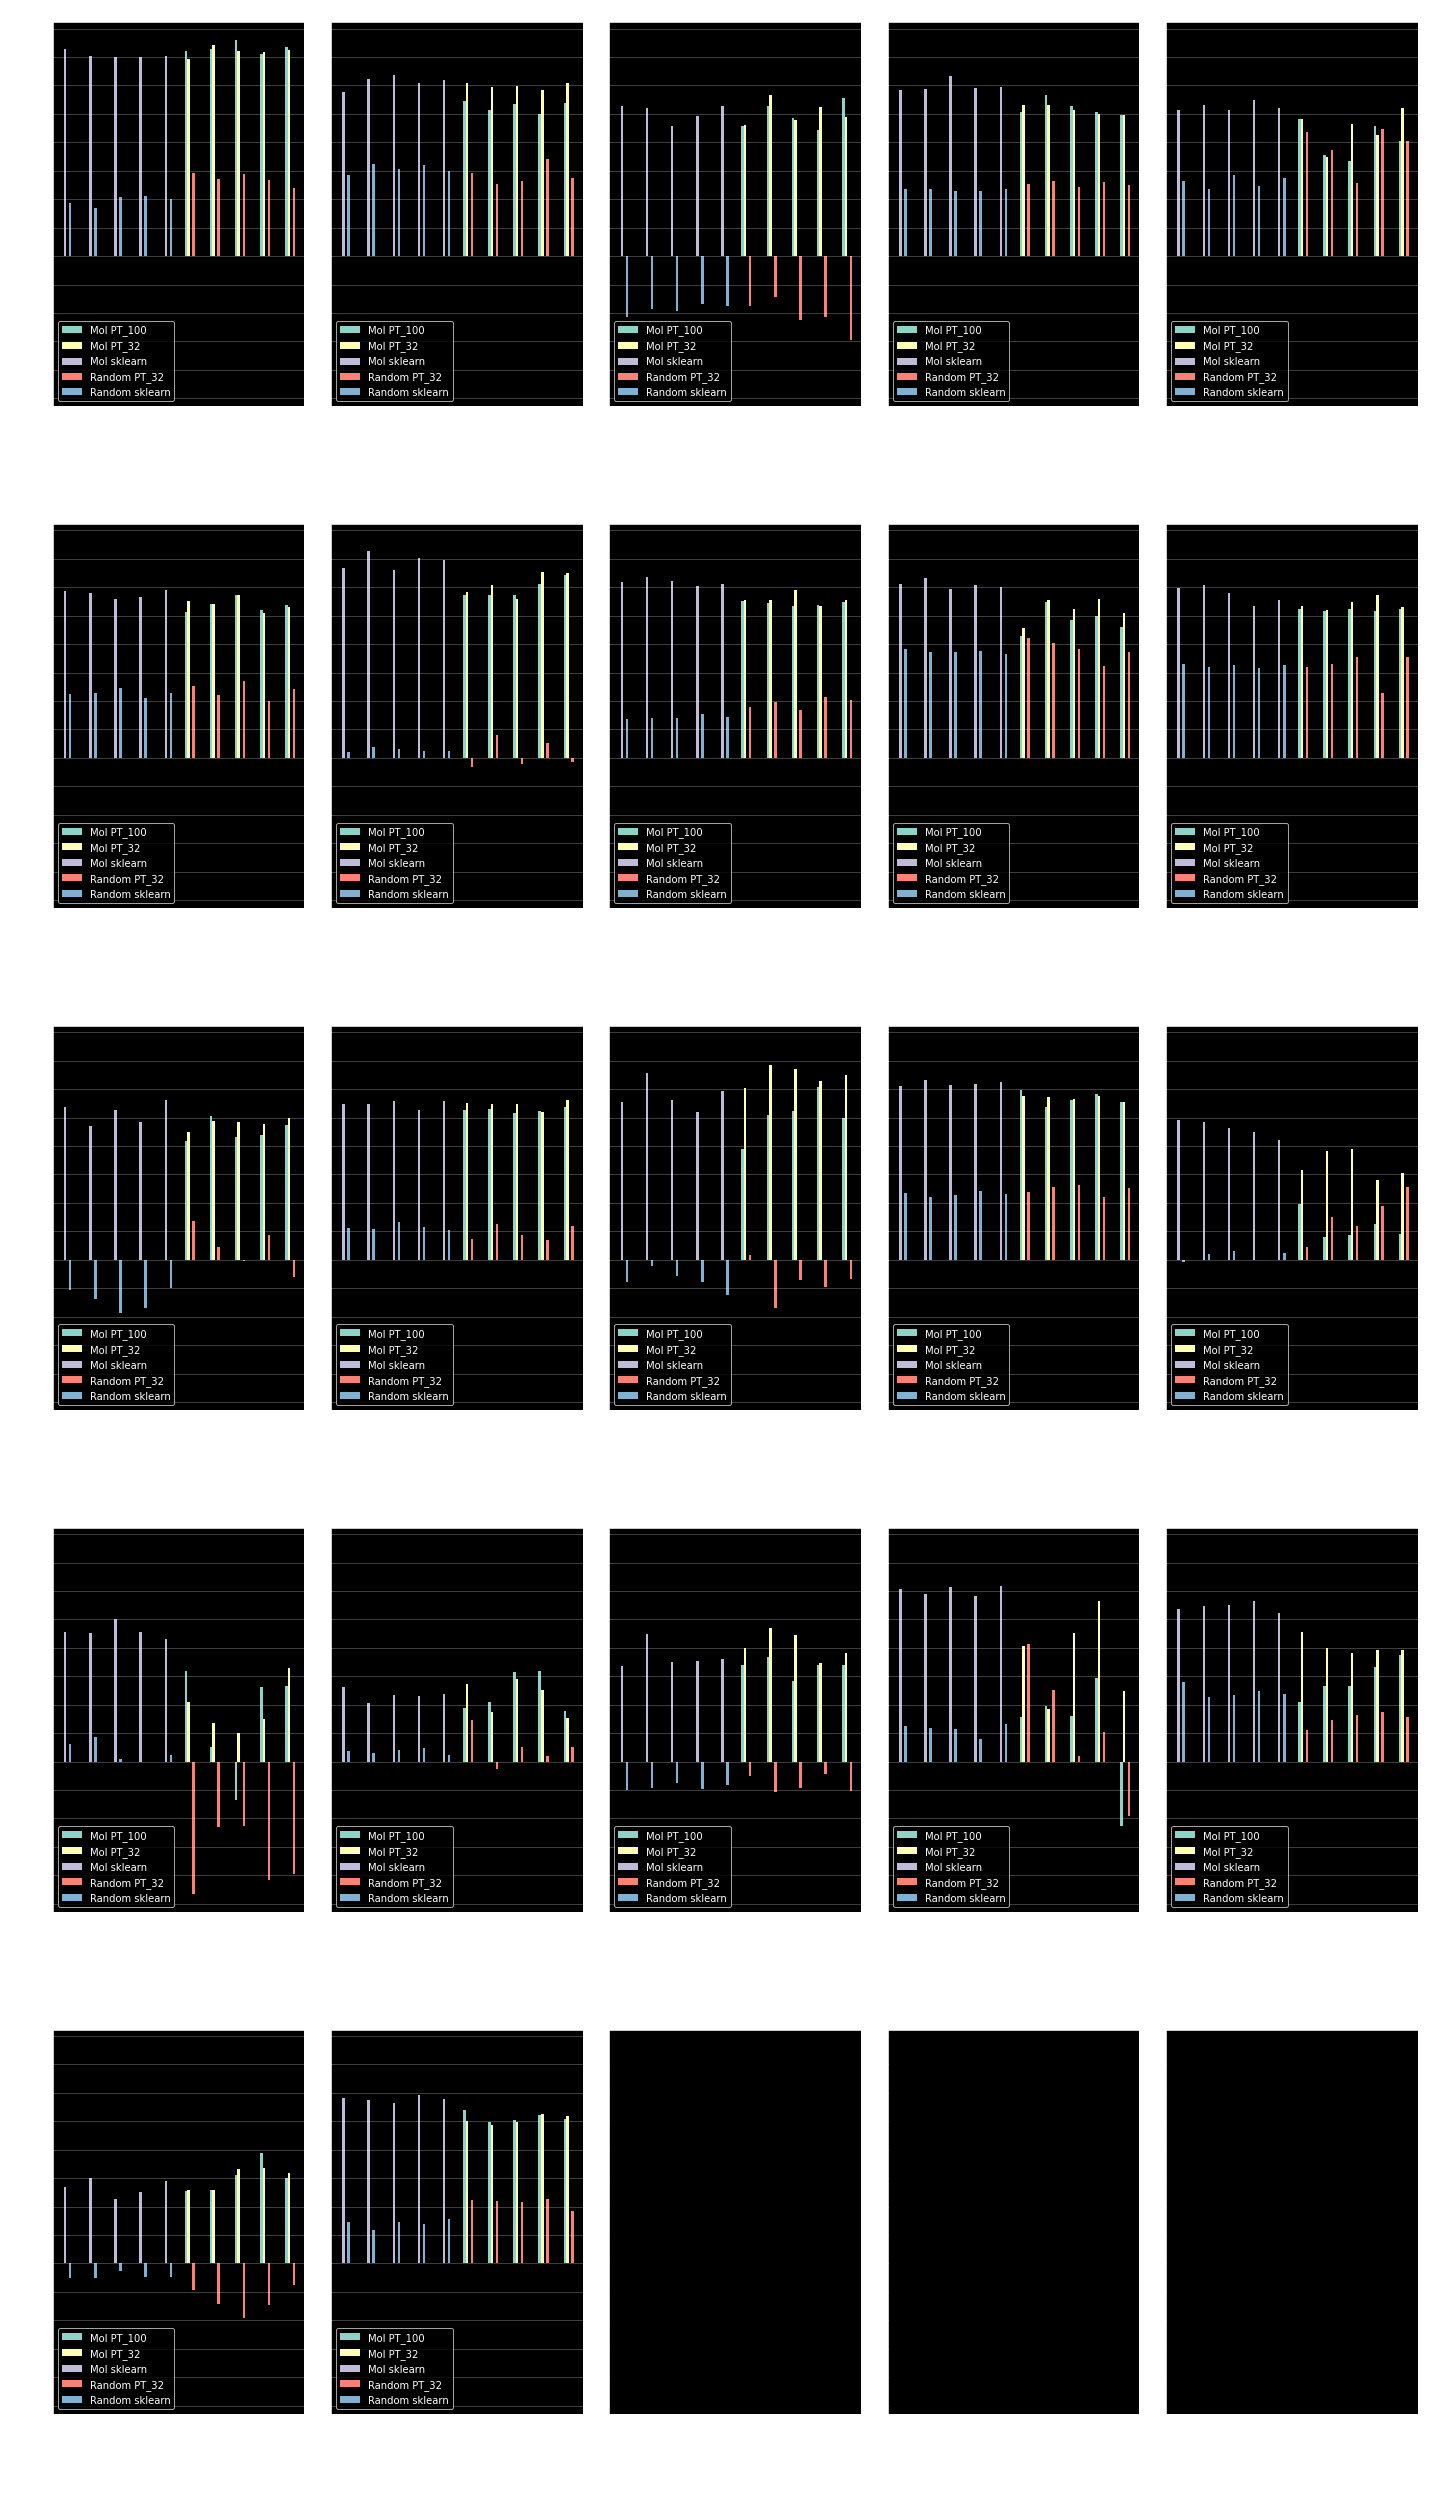

In [26]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
    ax_list = axes.flat

    i = 0
    for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
        nb_obs = rows[count_key].drop_duplicates().values[0]
        rows = rows.set_index(['model_type', "train_setup"], drop = True).sort_values( by = ["train_setup", metric])
        rows = rows.unstack("train_setup")
        rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
        ax_list[i].set_ylabel(metric)
        ax_list[i].legend(loc="lower left")
        ylims = [0.1*round(lim/0.1) for lim in ax_list[i].get_ylim()]
        ax_list[i].set_yticks(np.arange(ylims[0], ylims[1]+0.1, 0.1))
        ax_list[i].grid(visible=True, alpha=0.3, axis='y')

        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    # plt.subplots_adjust(hspace=0.5)
    # fig.suptitle(f"TASK NAME: {TASK_NAME}")
    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"scores_all_matrices.pdf")



Global scores across model types:

Plot results for task regression_on_detected:


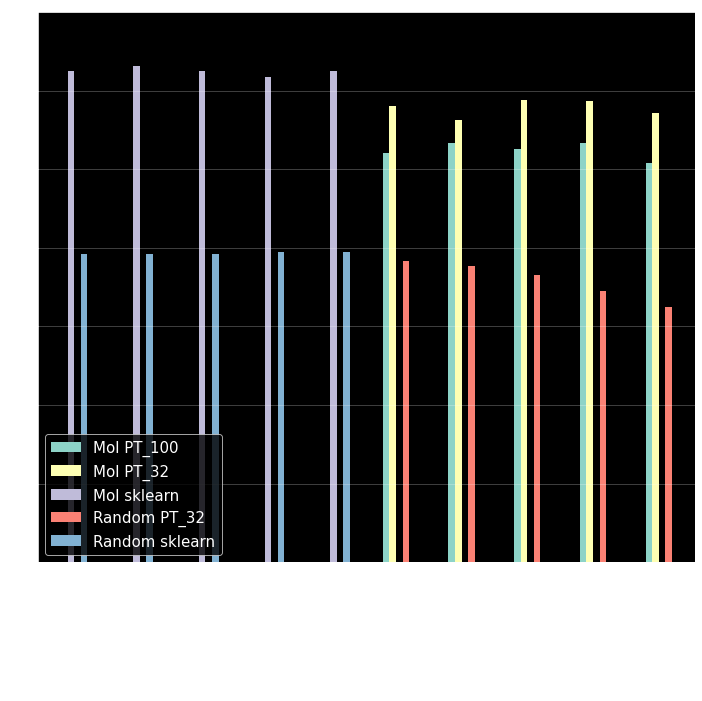

In [27]:
if not EVAL_FEAT_SEL:
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 10))
    print(f"Plot results for task {TASK_NAME}:")
    model_metrics_global.set_index(["model_type", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(ax=ax)
    ax.legend(loc="lower left")
    ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    ax.set_yticks(np.arange(ylims[0], ylims[1]+0.1, 0.1))
    ax.grid(visible=True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"scores_global.pdf")


### Show scores for a specific model type

In [ ]:
if "rank" in TASK_NAME or (TASK_NAME == "pytorch_nn_detection"):
    selected_model = "NN"
else:
    selected_model = "MLP"

In [ ]:
if not EVAL_FEAT_SEL:
    plotted_model_metrics = model_metrics[model_metrics.model_type == selected_model]
    plotted_model_metrics_global = model_metrics_global[model_metrics_global.model_type == selected_model]

    plotted_model_metrics_global.loc[:,"matrix"] = "GLOBAL"
    plotted_model_metrics_global.loc[:,"polarity"] = "all matrices"

    plotted_model_metrics = pd.concat([plotted_model_metrics, plotted_model_metrics_global],
                                      ignore_index=True)


In [ ]:
# filtered = plotted_model_metrics[plotted_model_metrics.train_setup == "pred_val>0.95"]
# filtered
# filtered.detected + filtered.not_detected
plotted_model_metrics["total_points"] = plotted_model_metrics["detected"] + plotted_model_metrics["not_detected"]

In [ ]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (10, 10))
    plt.rcParams.update({'font.size': 16})
    plotted_model_metrics["Matrix (polarity)"] = plotted_model_metrics["matrix"] + " (" + plotted_model_metrics["polarity"] + ")"


    plotted_model_metrics.set_index(["Matrix (polarity)", "train_setup"], drop=True)["total_points"].unstack("train_setup").plot.bar(ax=ax)
    # ax.legend(loc="lower left")
    ax.set_ylabel("total_points")
    ax.set_ylim([0, 200])
    # ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    # ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # fig.savefig(plots_dir / f"{selected_model}_scores.pdf")

In [ ]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (10, 10))
    plt.rcParams.update({'font.size': 16})
    plotted_model_metrics["Matrix (polarity)"] = plotted_model_metrics["matrix"] + " (" + plotted_model_metrics["polarity"] + ")"


    plotted_model_metrics.set_index(["Matrix (polarity)", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(ax=ax)
    ax.legend(loc="lower left")
    ax.set_ylabel(metric)
    ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3)
    plt.tight_layout()
    fig.savefig(plots_dir / f"{selected_model}_scores.pdf")

In [ ]:
# models_predictions[models_predictions.train_setup == "Baseline 2"]
models_predictions[models_predictions.train_setup == "Thresh 0.95 and intensity > 2"]

#### Plot scatter plots in case of regression

Select the training setup on which to focus on:

In [190]:
selected_train_setup = "Fingerprints+Mol features"
# selected_train_setup = "Fingerprings features"
# selected_train_setup = "Mol features"
# selected_train_setup = "Baseline (only adduct info)"



In [191]:
if not EVAL_FEAT_SEL and task_typename == "regression" :
    print(f"Plot results for task {TASK_NAME}:")
    fig, axes = plt.subplots(ncols=5,nrows=5, figsize= (25, 30))
    ax_list = axes.flat



    i = 0
    for (matrix, polarity), rows in models_predictions.groupby(['matrix', 'polarity']):
        rows = rows[rows["train_setup"] == selected_train_setup]
        rows = rows[rows["observed_value"] > 0]
        rows[rows[model_typename] == selected_model].plot.scatter(x = 'observed_value', y= 'prediction',
                                                       ax = ax_list[i], title=f"{matrix}-{polarity}")
        i+=1

    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"{selected_model}_{selected_train_setup}_scatter_plot.pdf")



Only plot for DHB positive:

In [192]:
if not EVAL_FEAT_SEL and task_typename == "regression":
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 22})

    fig, ax = plt.subplots(ncols=1,nrows=1, figsize= (10, 10))
    # ax_list = axes.flat

    i = 0
    rows = models_predictions[(models_predictions.matrix == "DHB") & (models_predictions.polarity == "positive") & (models_predictions.train_setup == selected_train_setup)]
    rows = rows[rows["observed_value"] > 0]
    rows[rows[model_typename] == selected_model].plot.scatter(x = 'observed_value', y= 'prediction',
                                                       ax = ax, title="DHB-positive")

    # plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.tight_layout()
    plt.show()
    fig.savefig(plots_dir / f"{selected_model}_{selected_train_setup}_scatter_plot_DHB-positive.png")


### Plots for different adduct info


In [193]:
if not EVAL_FEAT_SEL:
    model_metrics, model_metrics_global, models_predictions, model_typename = \
        compute_scores(filenames, TASK_NAME, task_typename, EVAL_FEAT_SEL,
                   test_all_adduct_setups=True)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alberto-mac/EMBL_repos/spotting-project-regression/notebooks/../results/detection_per_mol_max/results_all_feat.csv'

In [194]:
if not EVAL_FEAT_SEL:
    plotted_model_metrics = model_metrics[
        (model_metrics.model_type == selected_model) &
        (model_metrics.train_setup == selected_train_setup)
    ]
    plotted_model_metrics_global = model_metrics_global[
        (model_metrics_global.model_type == selected_model) &
        (model_metrics_global.train_setup == selected_train_setup)
    ]

    plotted_model_metrics_global.loc[:,"matrix"] = "GLOBAL"
    plotted_model_metrics_global.loc[:,"polarity"] = "all matrices"

    plotted_model_metrics = pd.concat([plotted_model_metrics, plotted_model_metrics_global],
                                      ignore_index=True)

ValueError: cannot set a frame with no defined index and a scalar

Plot results for task detection_per_mol_max:


KeyError: 'macro_avg_f1_score'

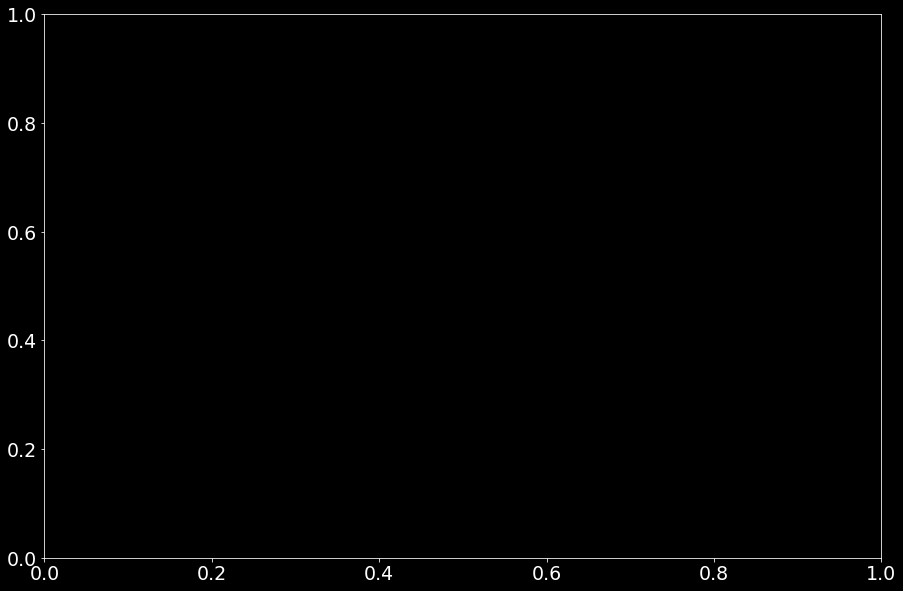

In [195]:
if not EVAL_FEAT_SEL:
    print(f"Plot results for task {TASK_NAME}:")
    plt.rcParams.update({'font.size': 19})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (15, 10))
    plotted_model_metrics["Matrix (polarity)"] = plotted_model_metrics["matrix"] + " (" + plotted_model_metrics["polarity"] + ")"

    plotted_model_metrics.set_index(["Matrix (polarity)", "adduct_setup"], drop=True)[metric].unstack("adduct_setup").plot.bar(ax=ax)
    ax.legend(loc="lower left")
    ax.set_ylabel(metric)
    ylims = [0.1*round(lim/0.1) for lim in ax.get_ylim()]
    ax.set_yticks(np.arange(ylims[0], ylims[1]+1*0.1, 0.1))
    ax.grid(visible=True, alpha=0.3)
    plt.tight_layout()
    fig.savefig(plots_dir / f"{selected_model}_{selected_train_setup}_adduct_setup_comparison.pdf")




### Plots for selecting pred_val_thresh

First, combine multiple csv in a single one:

In [100]:

foldernames_key = "val"
file_to_load = "results_mol_feat.csv"
# model_metrics, model_metrics_global, models_predictions, model_typename = \
#         compute_scores(filenames, TASK_NAME, task_typename, EVAL_FEAT_SEL,
#                    test_all_adduct_setups=True)

In [101]:
all_results = pd.DataFrame()
for root, dirs, files in os.walk(results_dir, topdown=False):
    for dirname in dirs:
        if foldernames_key in dirname:
            # Deduce value of the threshold from the folder name:
            pred_val_thresh = eval("0." + dirname.split("_")[1][1:])
            loc_results = pd.read_csv(os.path.join(root, dirname, file_to_load), index_col=0)
            loc_results["pred_val_thresh"] = pred_val_thresh
            all_results = pd.concat([all_results, loc_results])
all_results.to_csv(results_dir / "thresh_results_combined.csv")

In [102]:
model_metrics, model_metrics_global, models_predictions, model_typename = compute_scores({"All features": "thresh_results_combined.csv"}, TASK_NAME, task_typename, EVAL_FEAT_SEL,
                   load_multiple_thresholds=True, thresh_column_name="pred_val_thresh")


In [103]:
model_metrics


,matrix,polarity,train_setup,model_type,adduct_setup,pred_val_thresh,not_det_precision,not_det_recall,not_det_f1,not_detected,det_precision,det_recall,det_f1,detected,macro_avg_f1_score
0,9AA,negative,All features,MLP,All adducts,0.05,0.551020,0.586957,0.568421,46,0.833333,0.811966,0.822511,117,0.695466
1,9AA,negative,All features,MLP,All adducts,0.10,0.585366,0.533333,0.558140,45,0.827869,0.855932,0.841667,118,0.699903
2,9AA,negative,All features,MLP,All adducts,0.20,0.543478,0.609756,0.574713,41,0.863248,0.827869,0.845188,122,0.709950
3,9AA,negative,All features,MLP,All adducts,0.30,0.523810,0.564103,0.543210,39,0.859504,0.838710,0.848980,124,0.696095
4,9AA,negative,All features,MLP,All adducts,0.40,0.538462,0.538462,0.538462,39,0.854839,0.854839,0.854839,124,0.696650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,pNA,positive,All features,MLP,All adducts,0.10,0.534483,0.659574,0.590476,47,0.849057,0.769231,0.807175,117,0.698826
128,pNA,positive,All features,MLP,All adducts,0.20,0.500000,0.575000,0.534884,40,0.857143,0.816000,0.836066,125,0.685475
129,pNA,positive,All features,MLP,All adducts,0.30,0.500000,0.589744,0.541176,39,0.865546,0.817460,0.840816,126,0.690996
130,pNA,positive,All features,MLP,All adducts,0.40,0.500000,0.567568,0.531646,37,0.869919,0.835938,0.852590,128,0.692118


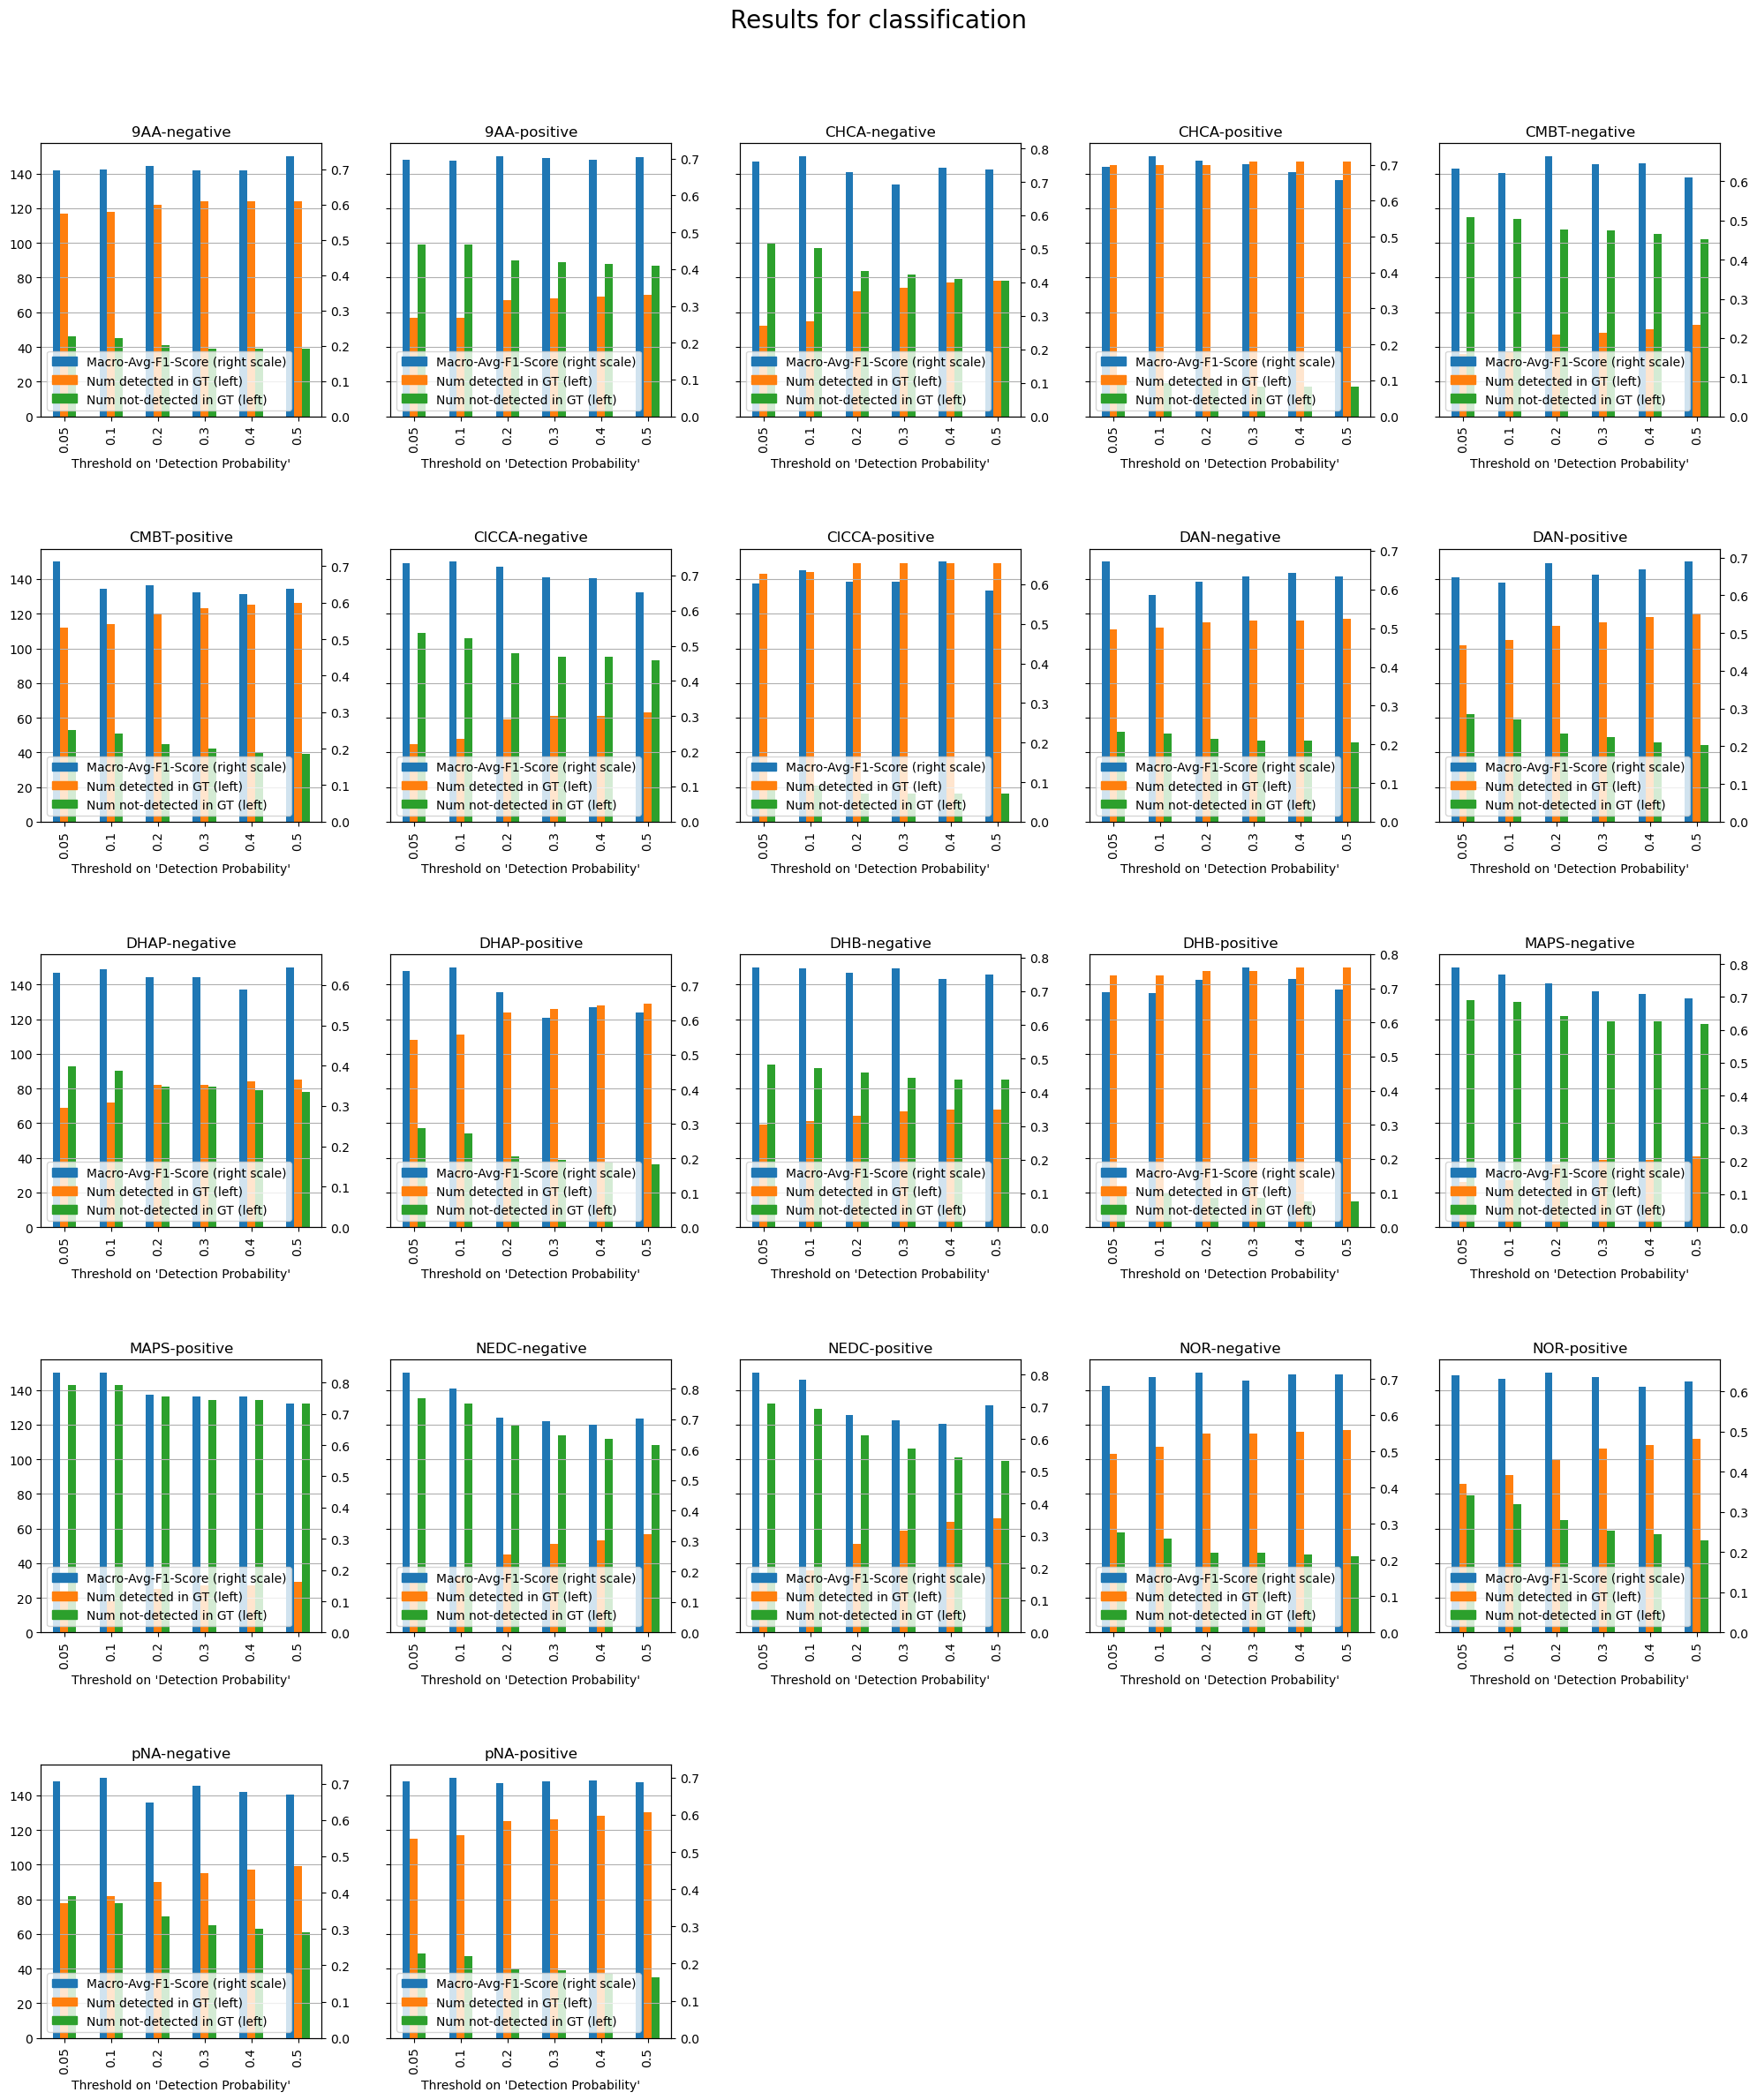

In [105]:
import matplotlib.patches as mpatches

quantities_to_plot = {
    metric: metric,
    "non-zero obs": "Non-zero observations"
}
for q_to_plot in quantities_to_plot:
    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 25))
    ax_list = axes.flat

    plotted_metrics = model_metrics
    i = 0
    for (matrix, polarity), rows in plotted_metrics.groupby(['matrix', 'polarity']):
        # nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
        # nb_obs = rows[count_key].drop_duplicates().values[0]
        # rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
        # rows["quantile (nb_feat)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
        rows = rows.set_index(["pred_val_thresh"], drop = True).sort_values( by = ["pred_val_thresh"])
        # rows = rows.unstack("feat_sel_method")
        # ax_twin = ax_list[i].twinx()

        # Regression:

        # Classification:
        if task_typename == "classification":
            rows[[metric, "detected", "not_detected"]].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}",
                                                    secondary_y=metric, legend=False)
            L = [mpatches.Patch(color=c, label=col)
                 for col,c in zip([f"Macro-Avg-F1-Score (right scale)", "Num detected in GT (left)", "Num not-detected in GT (left)"], plt.rcParams['axes.prop_cycle'].by_key()['color'])]
        elif task_typename == "regression":
            rows[[metric, "non-zero obs"]].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}",
                                                    secondary_y="non-zero obs", legend=False)
            L = [mpatches.Patch(color=c, label=col)
                 for col,c in zip([f"{metric} (left scale)", "Non-zero observations in GT (right)"], plt.rcParams['axes.prop_cycle'].by_key()['color'])]



        # ax_list[i].set_ylabel(metric)
        ax_list[i].set_xlabel("Threshold on 'Detection Probability'")
        # ax_list[i].right_ax.set_ylabel("Non-zero observations")


        # ax_list[i].set_ylim(0.1, 0.75)
        # ax_list[i].right_ax.set_ylim(0, 450)

        ax_list[i].grid(axis='y')

        plt.legend(handles=L, loc=3)


        # ax_list[i].set_ylabel(quantities_to_plot[q_to_plot])
        # TODO: position legend
        # ax_list[i].legend(loc="lower right")
        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    # Delete axes of remaining plots:
    for ax_index in range(i, len(ax_list)):
        ax_list[ax_index].axis('off')

    # plt.subplots_adjust(hspace=0.5)
    fig.suptitle(f"Results for {task_typename}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=5, w_pad=3)
    plt.show()
    (plots_dir / "pred_val_thresh").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "pred_val_thresh"/ f"{q_to_plot}.pdf")
    break


## Plot results for feature selection
If `EVAL_FEAT_SEL==False`, nothing will be plotted in this section

In [136]:
# feature_sel_method = "kendall"
feature_sel_method = "mean_abs_shap"

,matrix,polarity,train_setup,model_type,adduct_setup,feat_sel_method,quantile,nb_features,Spearman's R,S pval,Pearson's R,P pval,RMSE,RMSE/std,non-zero obs
0,9AA,negative,All features,MLP,All adducts,mean_abs_shap,0,365,0.671093,4.466782e-23,0.656081,8.464124e-22,1.020367,0.817227,166
1,9AA,negative,All features,MLP,All adducts,mean_abs_shap,1,303,0.697768,1.532359e-25,0.682569,4.186002e-24,0.966210,0.773852,166
2,9AA,negative,All features,MLP,All adducts,mean_abs_shap,2,241,0.675083,1.984885e-23,0.646887,4.729456e-21,1.038767,0.831965,166
3,9AA,negative,All features,MLP,All adducts,mean_abs_shap,3,179,0.668915,6.917070e-23,0.651590,1.976107e-21,1.020522,0.817351,166
4,9AA,negative,All features,MLP,All adducts,mean_abs_shap,4,117,0.674771,2.115895e-23,0.658316,5.520691e-22,0.998534,0.799741,166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,2,241,0.766678,6.405755e-53,0.783092,1.355531e-56,0.599725,0.634430,267
458,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,3,179,0.746029,1.050905e-48,0.758248,3.789295e-51,0.636109,0.672920,267
459,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,4,117,0.658824,1.294874e-34,0.663669,2.843786e-35,0.739121,0.781893,267
460,pNA,positive,All features,MLP,No radicals adducts '[M]+'/'[M]-' and only met...,mean_abs_shap,5,55,0.516334,1.349566e-19,0.525371,2.396052e-20,0.862560,0.912476,267


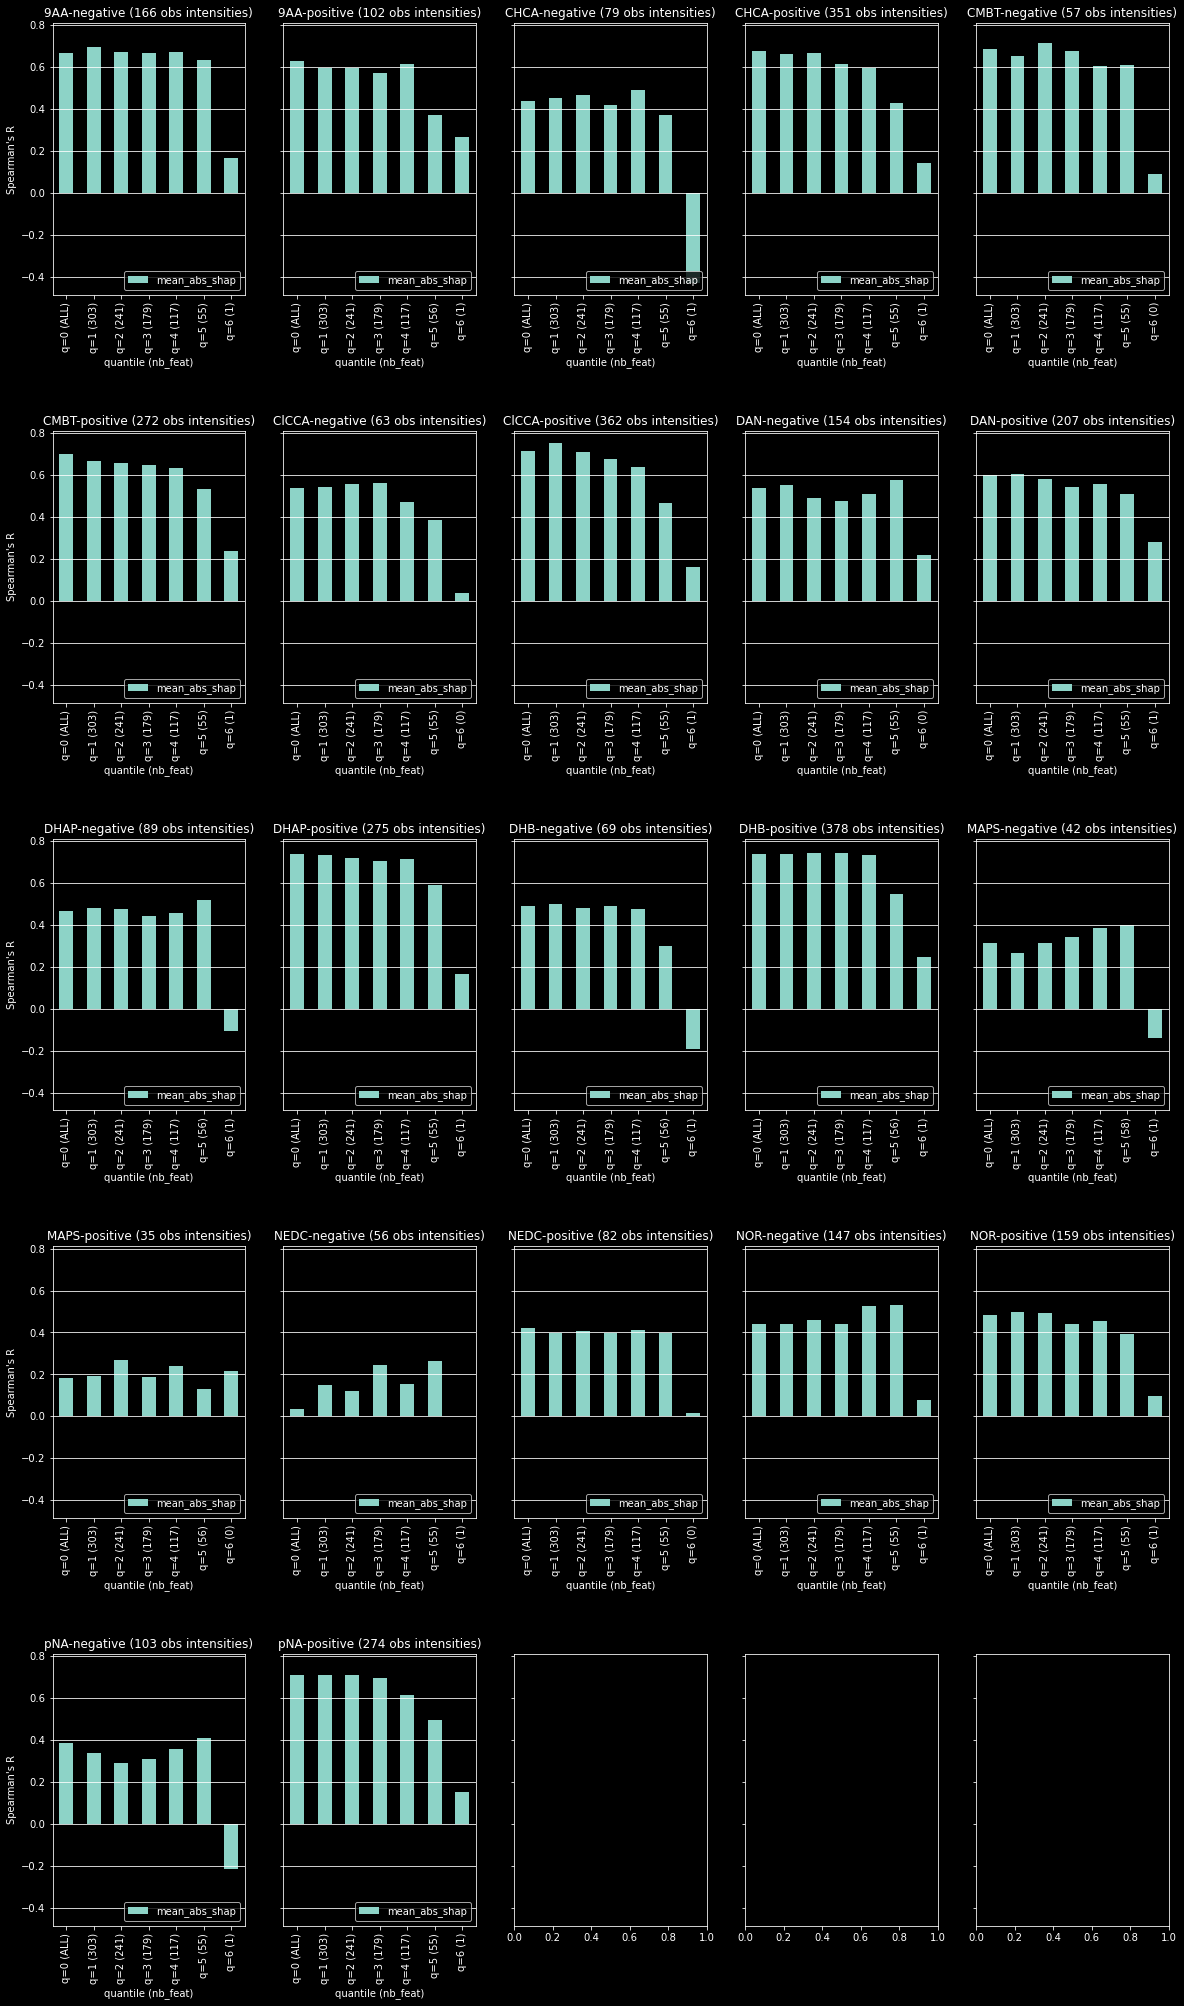

In [141]:
if EVAL_FEAT_SEL:

    plt.rcParams.update({'font.size': 10})
    fig, axes = plt.subplots(ncols=5,nrows=5, sharey=True, figsize= (20, 35))
    ax_list = axes.flat

    plotted_metrics = model_metrics[model_metrics.feat_sel_method == feature_sel_method]
    i = 0
    for (matrix, polarity), rows in plotted_metrics.groupby(['matrix', 'polarity']):
        # nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
        nb_obs = rows[count_key].drop_duplicates().values[0]
        rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
        rows["quantile (nb_feat)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
        rows = rows.set_index(["quantile (nb_feat)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
        rows = rows.unstack("feat_sel_method")
        rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs} obs intensities)")
        ax_list[i].set_ylabel(metric)
        ax_list[i].grid(axis='y')
        # TODO: position legend
        ax_list[i].legend(loc="lower right")
        # if i != 0:
        #     ax_list[i].get_legend().set_visible(False)
        i+=1

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    (plots_dir / "feat_selection").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}.pdf")


/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_79595/3160736158.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
/var/folders/xw/tcy65hq13818_4913hhp666h0000gq/T/ipykernel_79595/3160736158.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"


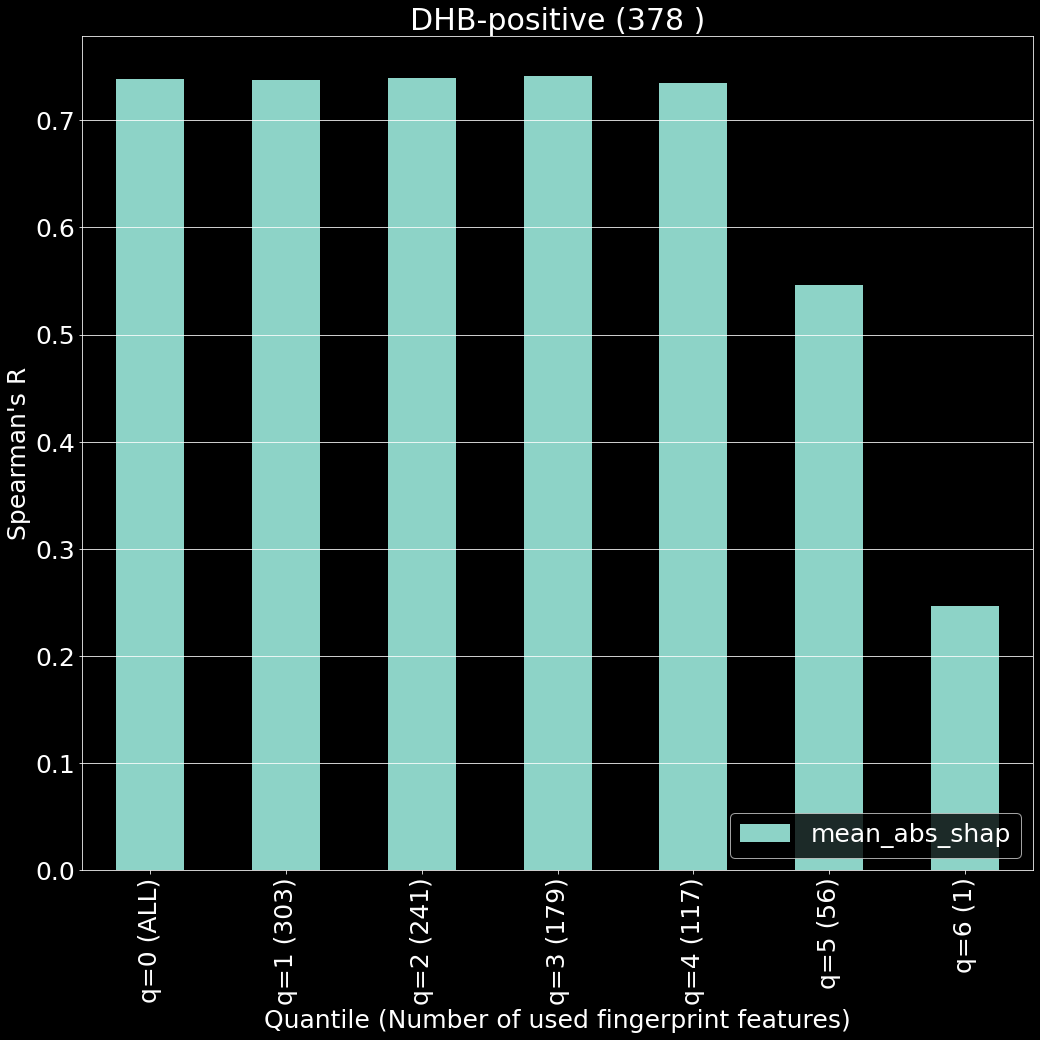

In [142]:
if EVAL_FEAT_SEL:
    plt.rcParams.update({'font.size': 25})
    fig, ax = plt.subplots(ncols=1,nrows=1, sharey=True, figsize= (15, 15))


    rows = model_metrics[(model_metrics.feat_sel_method == feature_sel_method) &
                                    (model_metrics.matrix == "DHB") & (model_metrics.polarity == "positive")]
    if "detection" in TASK_NAME:
        count_key = 'detected'
    elif "regression" in TASK_NAME:
        count_key = 'non-zero obs'
    nb_obs = rows[count_key].drop_duplicates().values[0]
    rows.loc[rows["nb_features"] == rows["nb_features"].max(), "nb_features"] = "ALL"
    rows["Quantile (Number of used fingerprint features)"] = "q=" + rows["quantile"].astype("str") + " (" + rows["nb_features"].astype("str") + ")"
    rows = rows.set_index(["Quantile (Number of used fingerprint features)", "feat_sel_method"], drop = True).sort_values( by = ["feat_sel_method", metric])
    rows = rows.unstack("feat_sel_method")
    rows[metric].plot.bar(ax = ax, title=f"DHB-positive ({nb_obs} )")
    ax.set_ylabel(metric)
    ax.grid(axis='y')
    # TODO: position legend
    ax.legend(loc="lower right")
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)

    # plt.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()
    (plots_dir / "feat_selection").mkdir(exist_ok=True)
    fig.savefig(plots_dir / "feat_selection"/ f"{feature_sel_method}-DHB-positive.pdf")

In [82]:
if EVAL_FEAT_SEL:
    model_metrics_global.set_index(['quantile', "feat_sel_method"], drop=True)[metric].unstack("feat_sel_method").plot.bar(figsize=(10,10))